### Project 2 for Machine Learning Course by Dr. Radi Jarrar, 
## Classification task for Weather Dataset 
Sondos Aabed

In [1]:
#Import necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

## Read the Weather dataset file

In [2]:
def read_file(name):
    dataframe = pd.read_csv(name) # Load the excel file into a data Structure
    print("Observations: ", len(dataframe))  # check the size of obsevations
    print("Features: ", dataframe.columns.size) # check number of features
    return dataframe

In [3]:
dataframe = read_file('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')

Observations:  145460
Features:  23


In [4]:
dataframe.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [5]:
dataframe.describe(include=['object'])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2017-06-18,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


In [6]:
# high cardinality of date needs to be handeled
def handle_date(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Year'] = dataframe['Date'].dt.year
    dataframe['Year'].head()
    dataframe['Month'] = dataframe['Date'].dt.month
    dataframe['Month'].head()
    dataframe['Day'] = dataframe['Date'].dt.month
    dataframe['Day'].head()
    dataframe.drop('Date', axis=1, inplace = True)

In [7]:
handle_date(dataframe)
dataframe.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,12
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,12
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,12
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,12
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,12


## Chapter one: Eploratory Data Analysis (EDA)

### Features Overview

- draw histograms for quantitative features

In [8]:
def histograms(dataframe):
    """
    Plots histograms of numerical columns in the dataframe in a grid layout.

    Args:
      dataframe: A pandas DataFrame containing the data.
    """
    fixed_bins_cols = ['Cloud3pm', 'Cloud9am']
    fixed_bins_fig, fixed_bins_axes = plt.subplots(1, len(fixed_bins_cols), figsize=(20, 6))  # Adjust figsize as needed

    for i, col in enumerate(fixed_bins_cols):
        fixed_bins_axes[i].hist(dataframe[col], bins=15, color='orange')
        fixed_bins_axes[i].set_xlabel(col)
        fixed_bins_axes[i].set_ylabel('Count')

    dynamic_bins_cols = [col for col in dataframe if col not in fixed_bins_cols and dataframe[col].dtype != object]  # Filter numerical columns
    n_rows = int(np.ceil(len(dynamic_bins_cols) / 3))  # Calculate number of rows for grid
    dynamic_bins_fig, dynamic_bins_axes = plt.subplots(n_rows, 3, figsize=(20, n_rows * 6))  # Adjust figsize as needed

    for i, col in enumerate(dynamic_bins_cols):
        row, col_index = divmod(i, 3)  # Get row and column index for grid placement
        dynamic_bins_axes[row, col_index].hist(dataframe[col], bins=int(np.sqrt(len(dataframe))), color='orange')  # Dynamic bin size
        dynamic_bins_axes[row, col_index].set_xlabel(col)
        dynamic_bins_axes[row, col_index].set_ylabel('Count')

    plt.tight_layout()

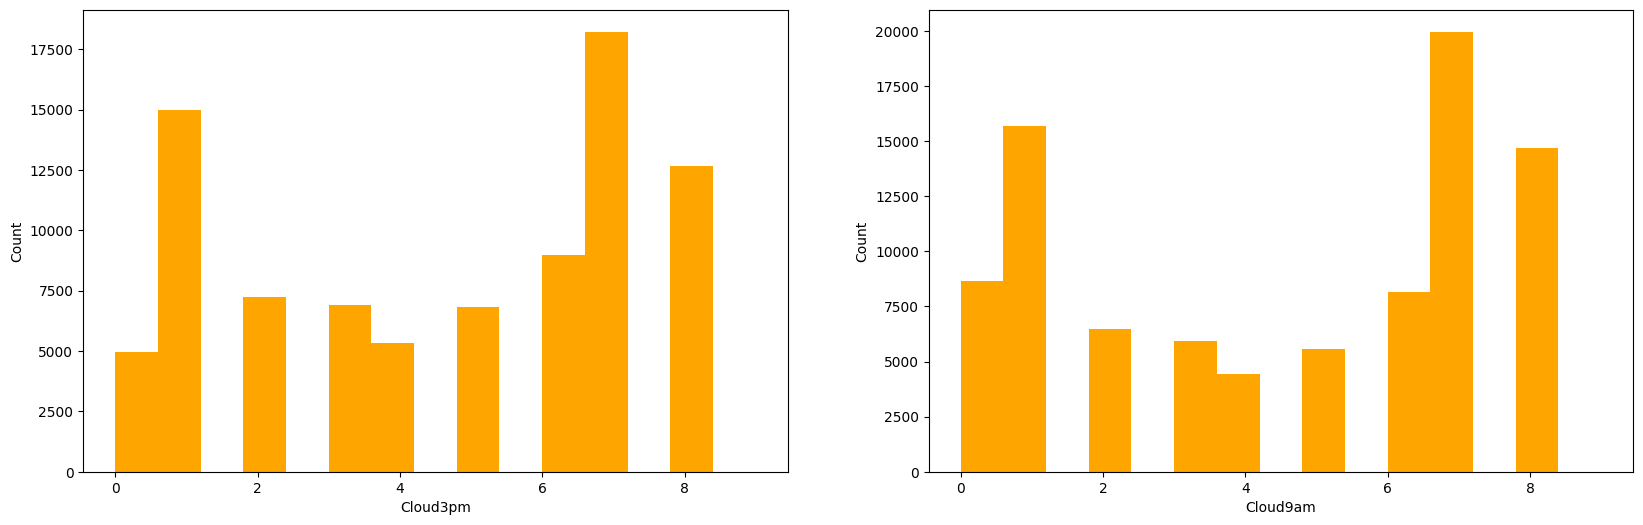

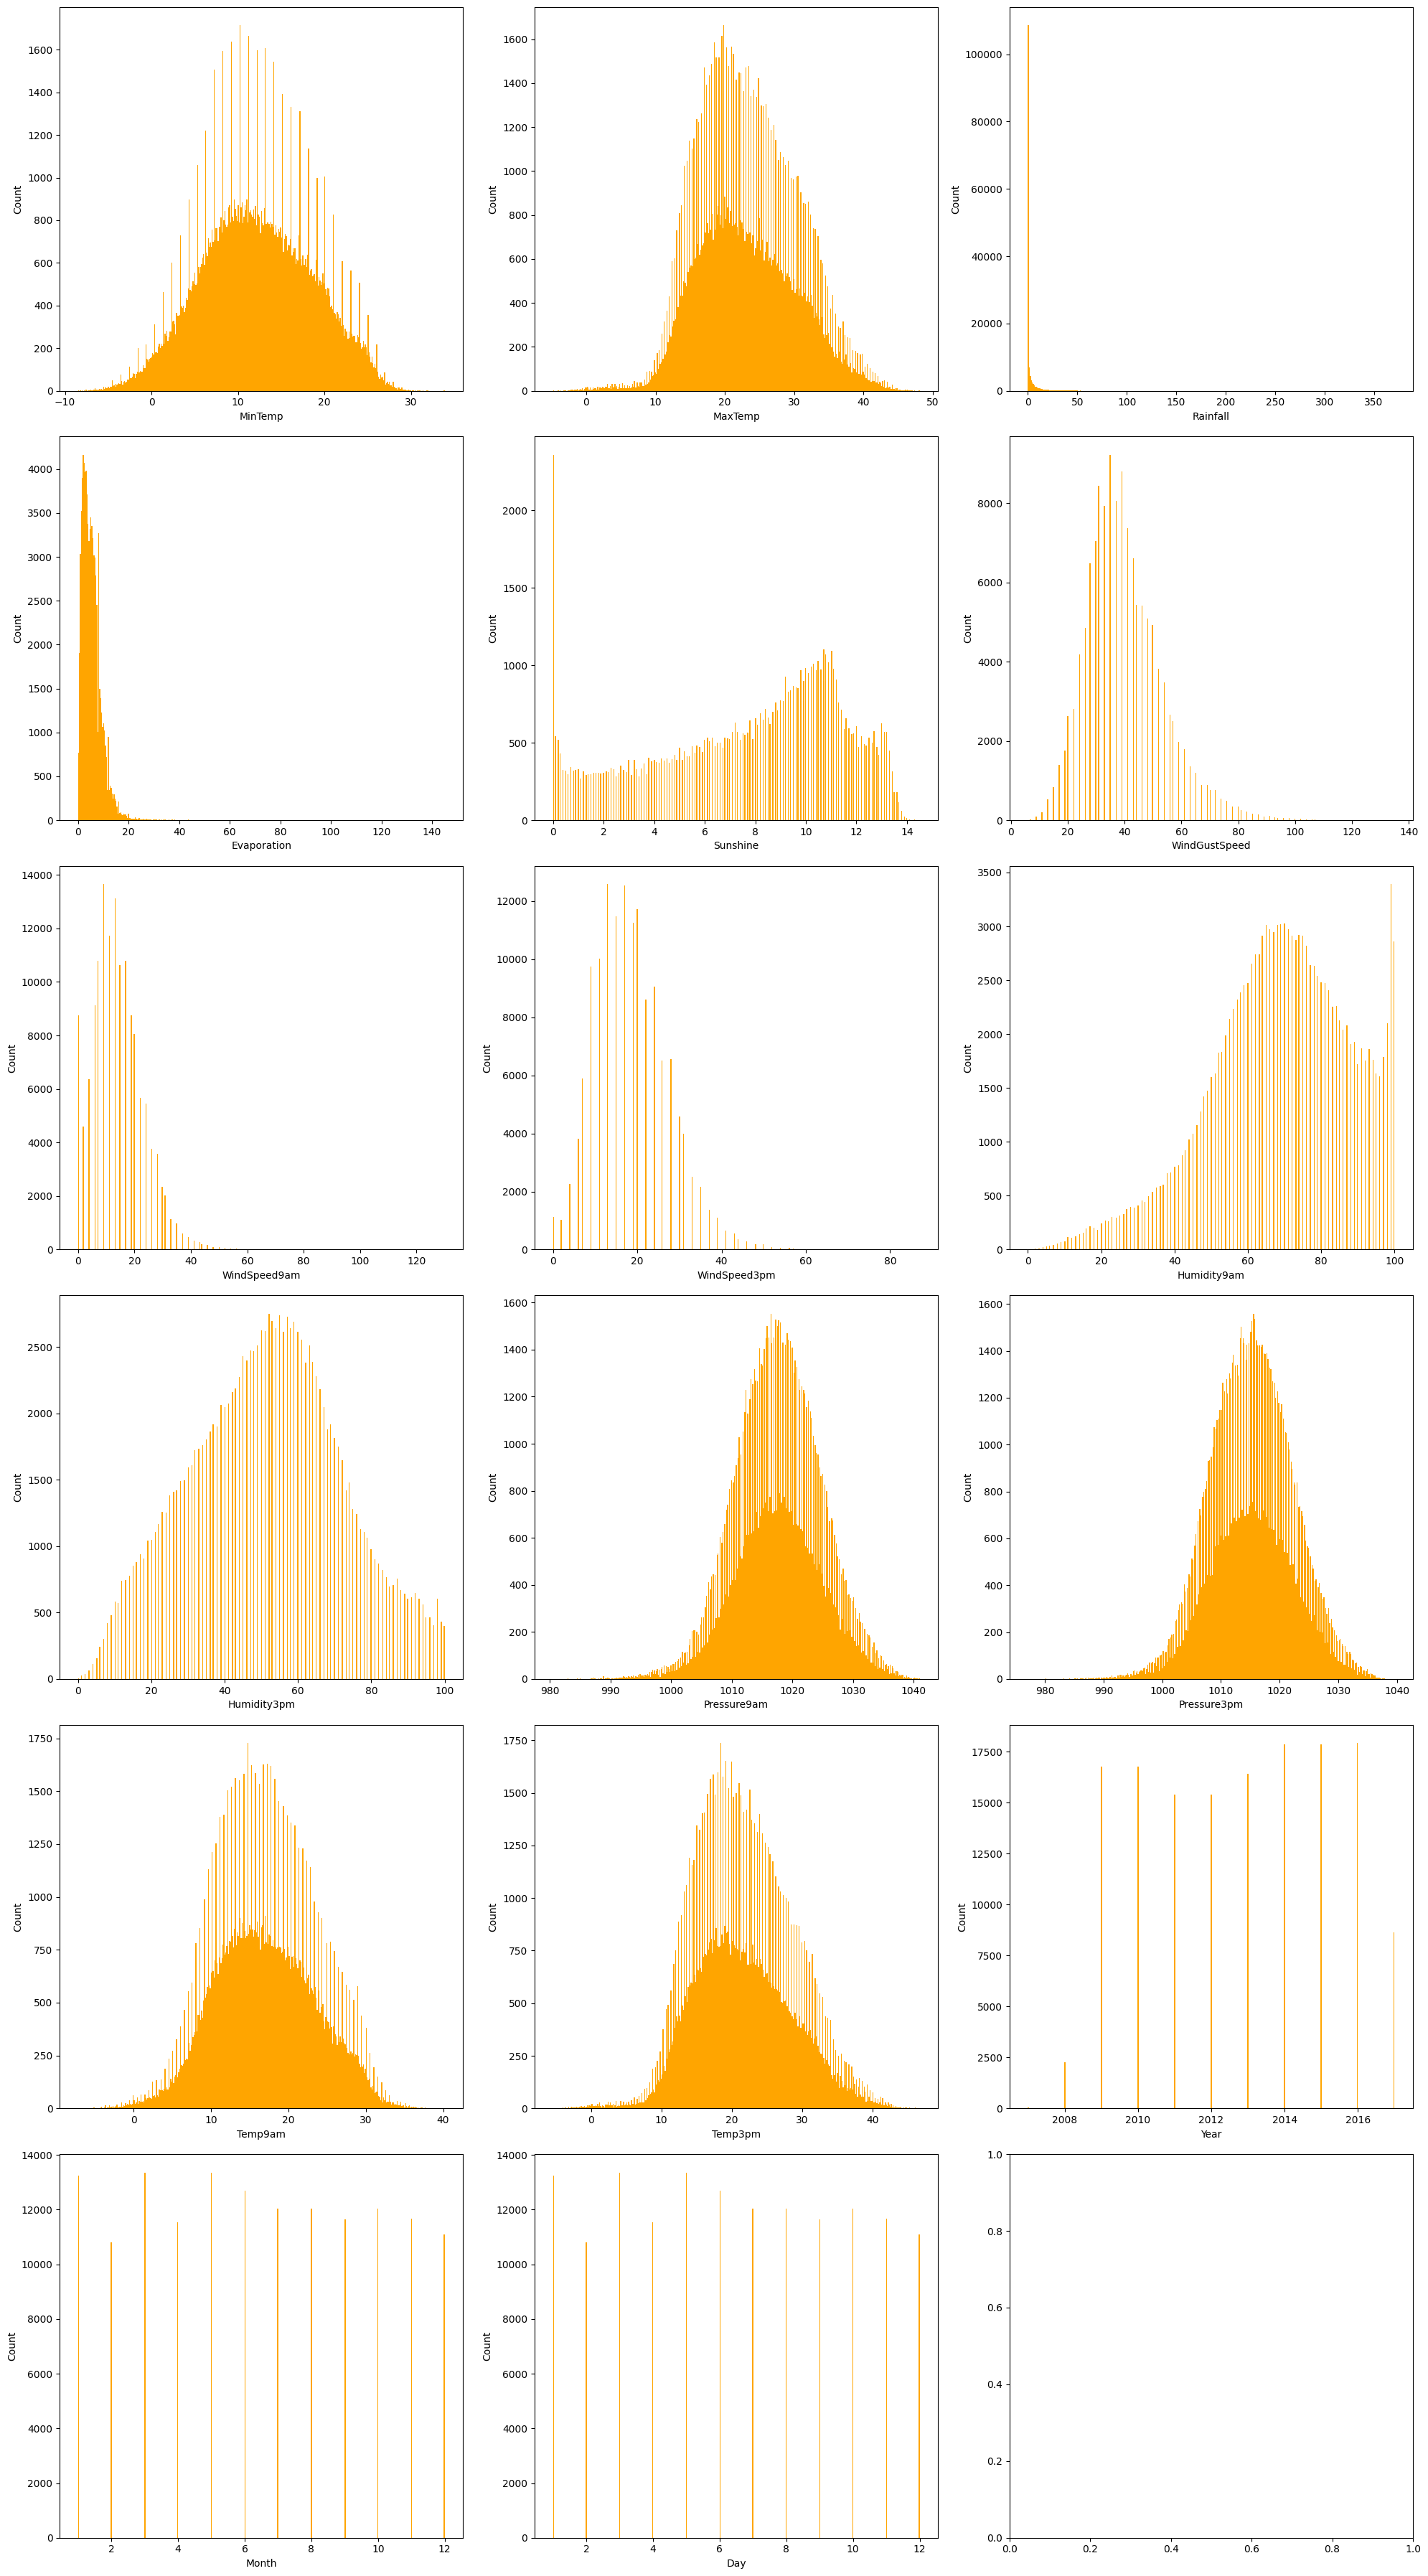

In [9]:
histograms(dataframe)

- draw pie Chart for qualitative features

In [10]:
def pies(dataframe, cols_per_row=3, figsize=(15, 10)):  # Added cols_per_row and figsize arguments
    """
    Plots pie charts for categorical columns in the dataframe in a grid layout.

    Args:
      dataframe: A pandas DataFrame containing the data.
      cols_per_row: Number of columns per row in the grid layout (default: 3).
      figsize: Figure size for the overall plot (default: (15, 10)).
    """

    qualitative_cols = [col for col in dataframe if dataframe[col].dtype == object]  # Filter categorical columns
    n_rows = int(np.ceil(len(qualitative_cols) / cols_per_row))  # Calculate number of rows for grid

    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=figsize)  # Create grid of axes

    for i, col in enumerate(qualitative_cols):
        row, col_index = divmod(i, cols_per_row)  # Get row and column index for grid placement

        # Ensure proper handling of single-row and single-column grids
        if n_rows == 1:
            axes[col_index].pie(dataframe[col].value_counts(), autopct='%1.1f%%', labels=None)  # Omit labels for single row
            axes[col_index].set_title(col)
        elif cols_per_row == 1:
            axes[row].pie(dataframe[col].value_counts(), autopct='%1.1f%%', labels=None)  # Omit labels for single column
            axes[row].set_title(col)
        else:
            axes[row, col_index].pie(dataframe[col].value_counts(), autopct='%1.1f%%')
            axes[row, col_index].set_title(col)

    plt.tight_layout()

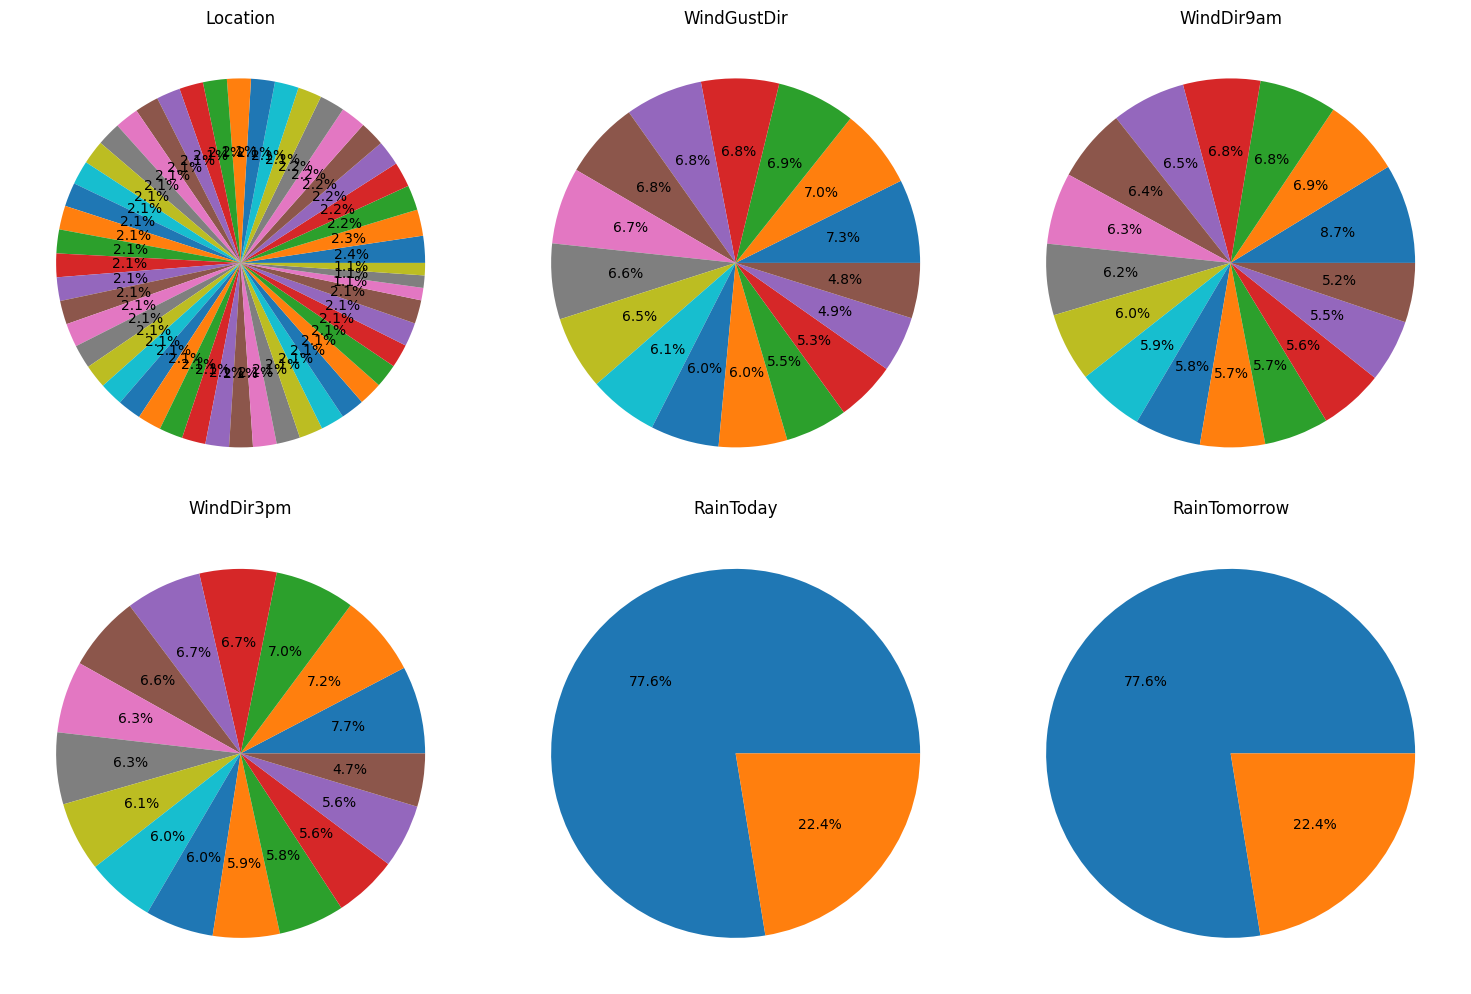

In [11]:
pies(dataframe)

## Data Cleansing

- draw box plots to detect outliers

In [12]:
def boxPlot(dataframe):
    for col in dataframe:
        if (dataframe[col].dtype != object and dataframe[col].dtype != '<M8[ns]') :
            # Plot the box plot for a specific column
            figure, axes = plt.subplots(figsize=(10, 8))
            sns.boxplot(dataframe[col],ax=axes)
            axes.set_title(col)

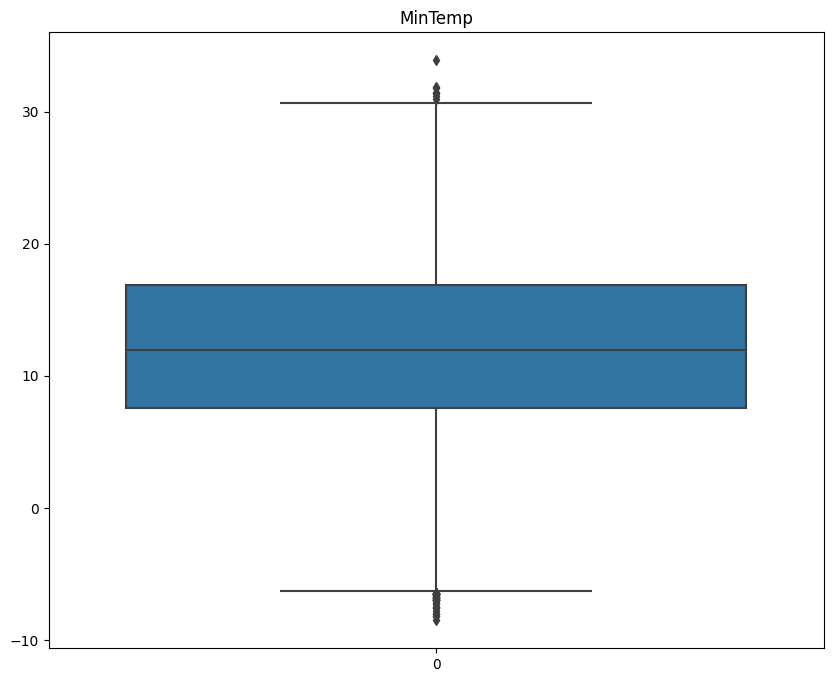

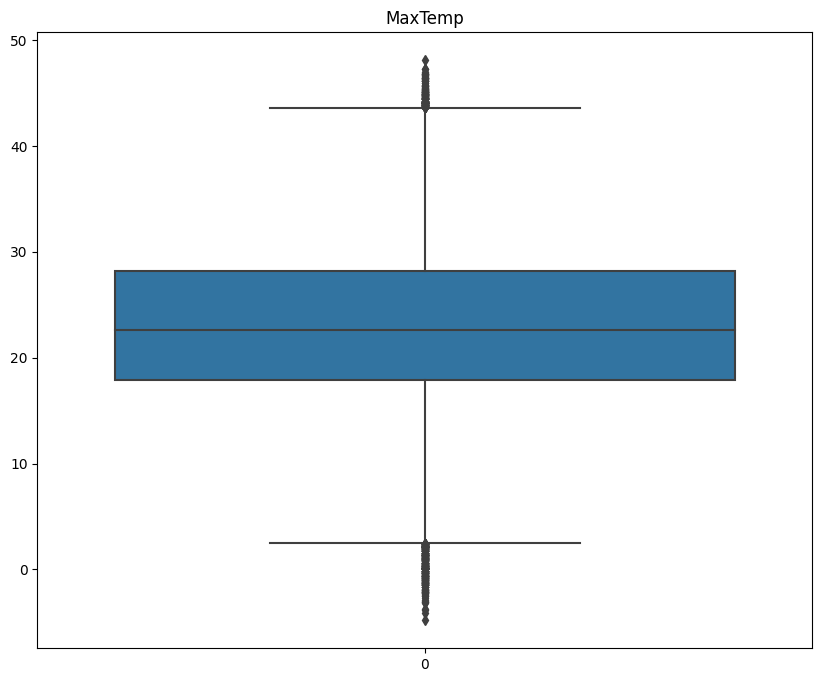

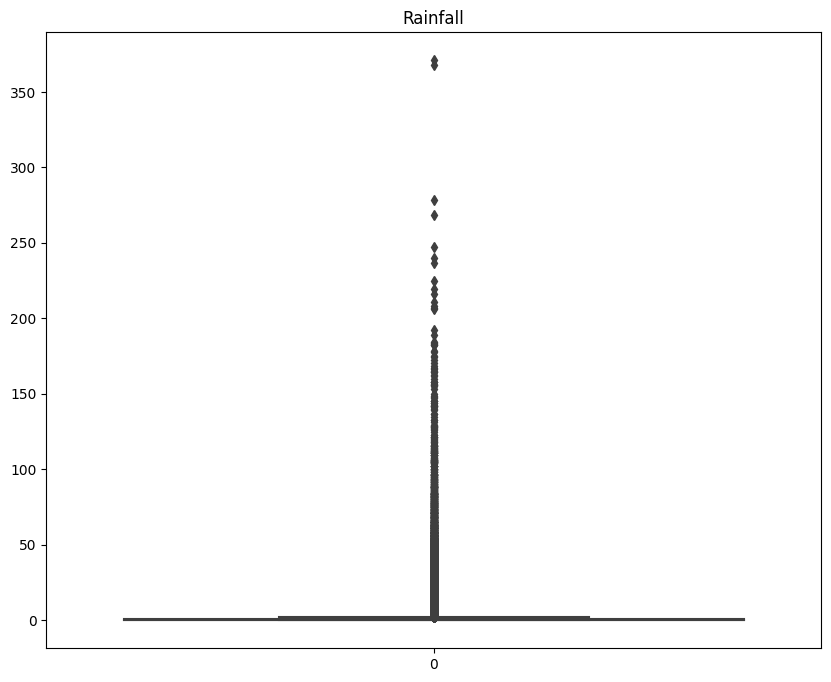

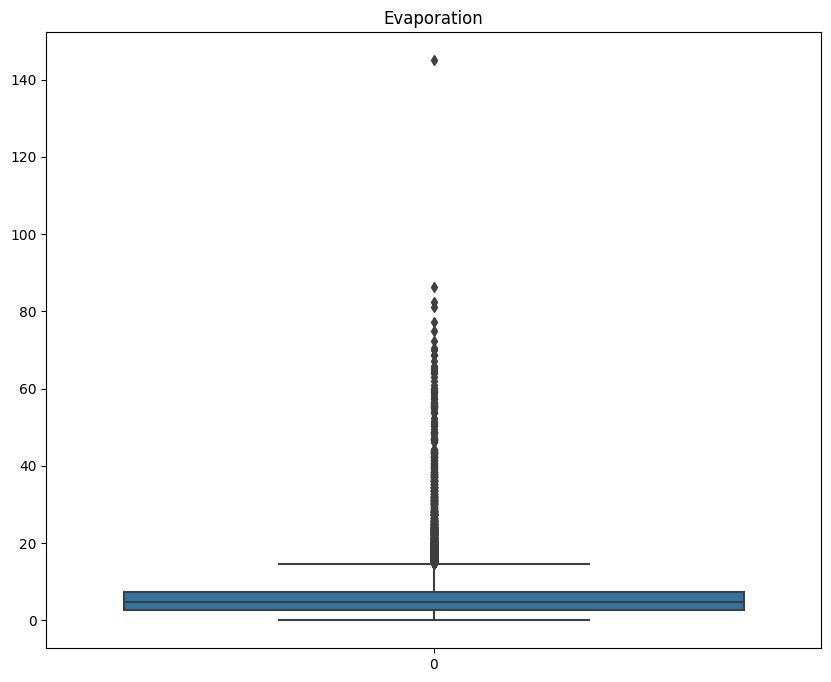

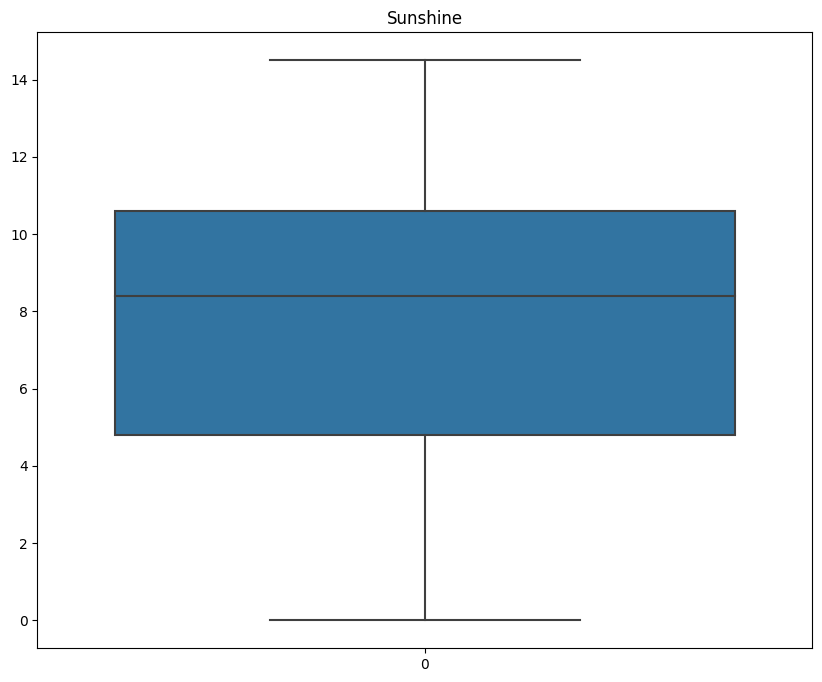

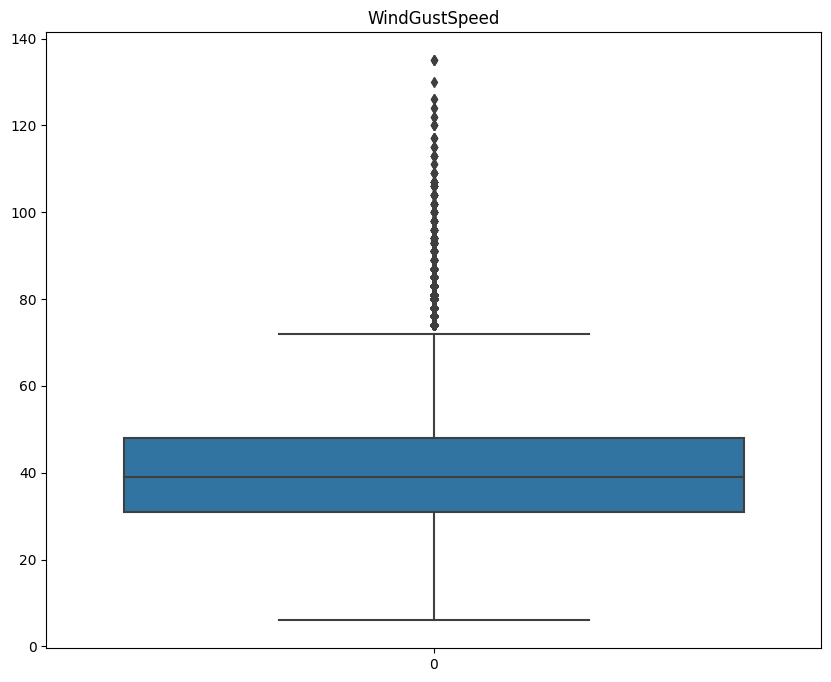

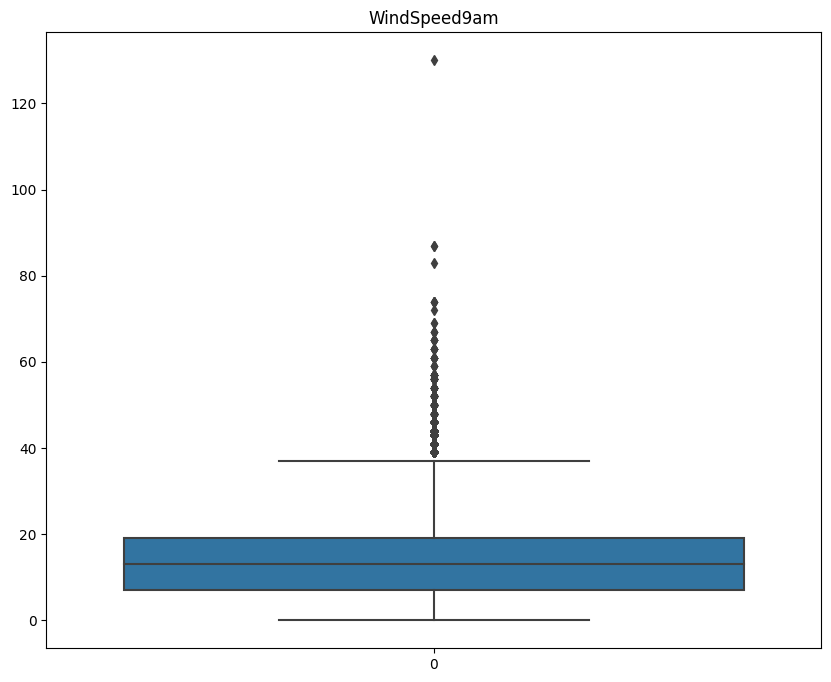

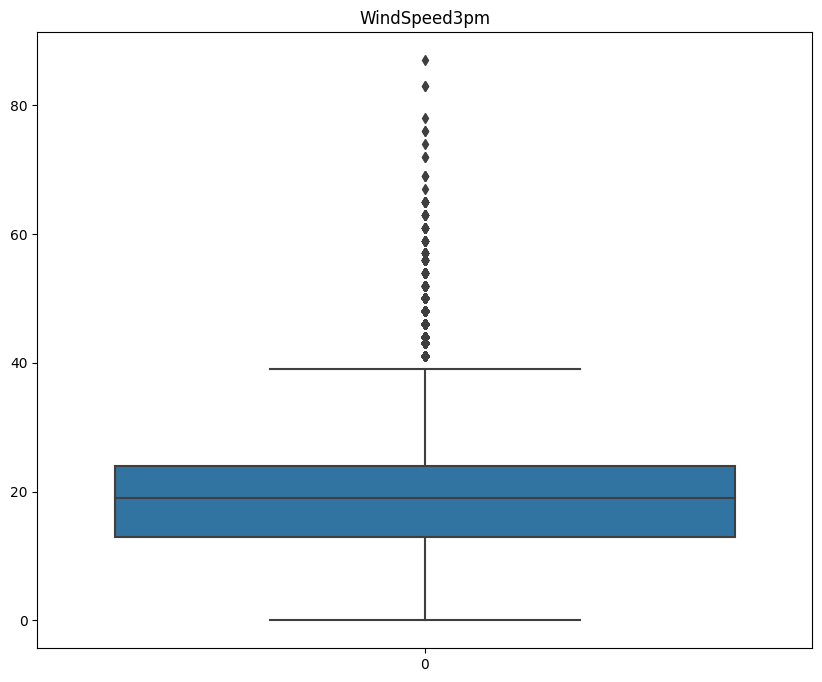

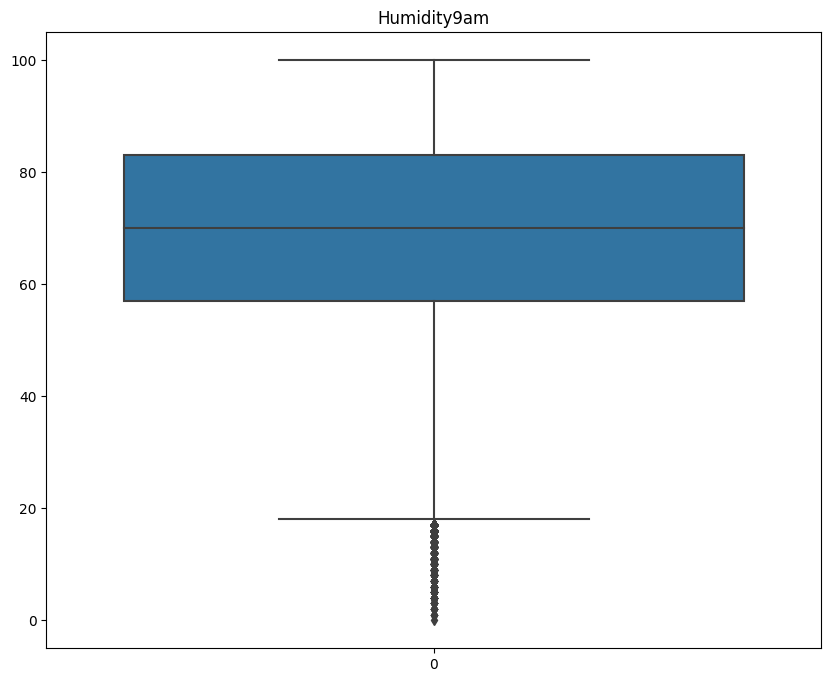

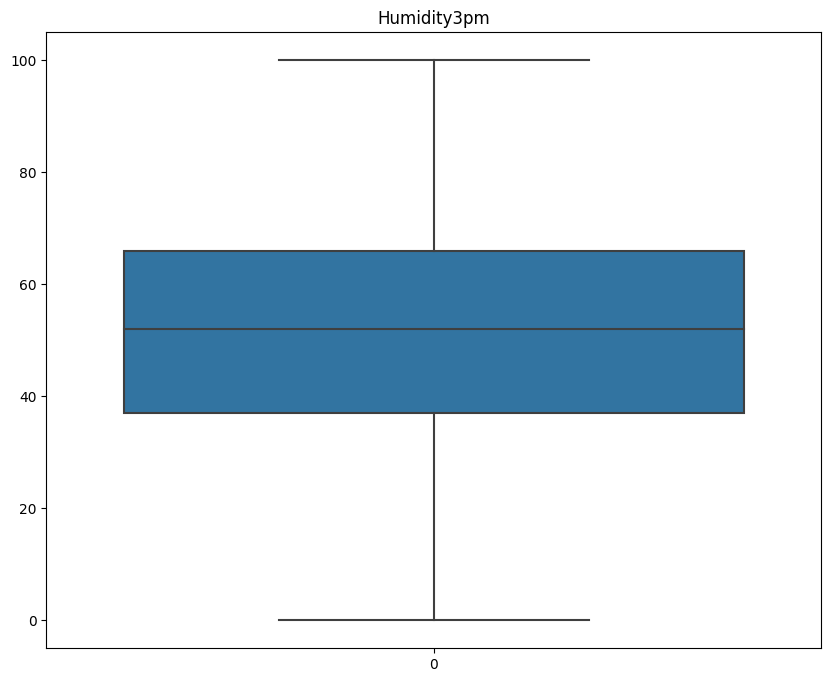

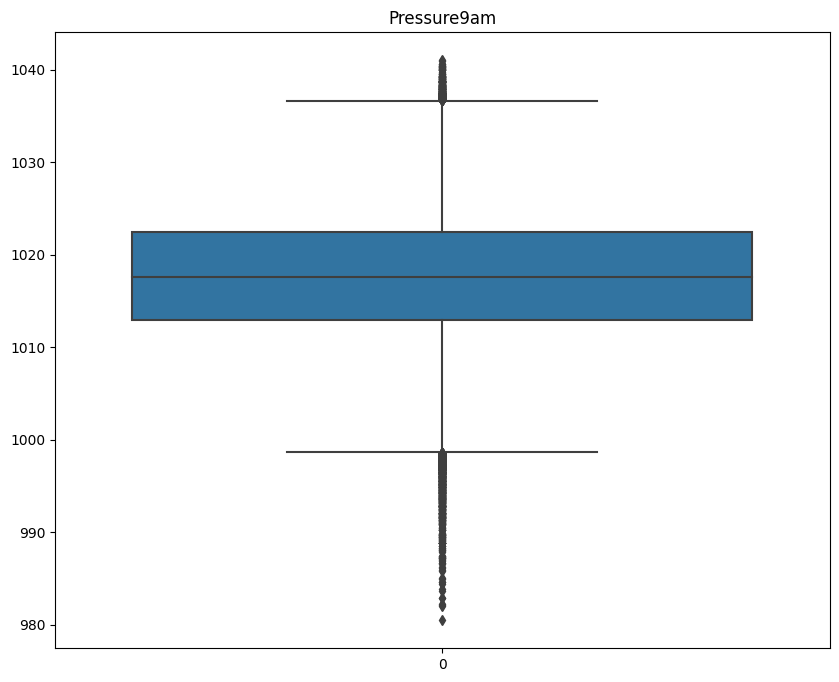

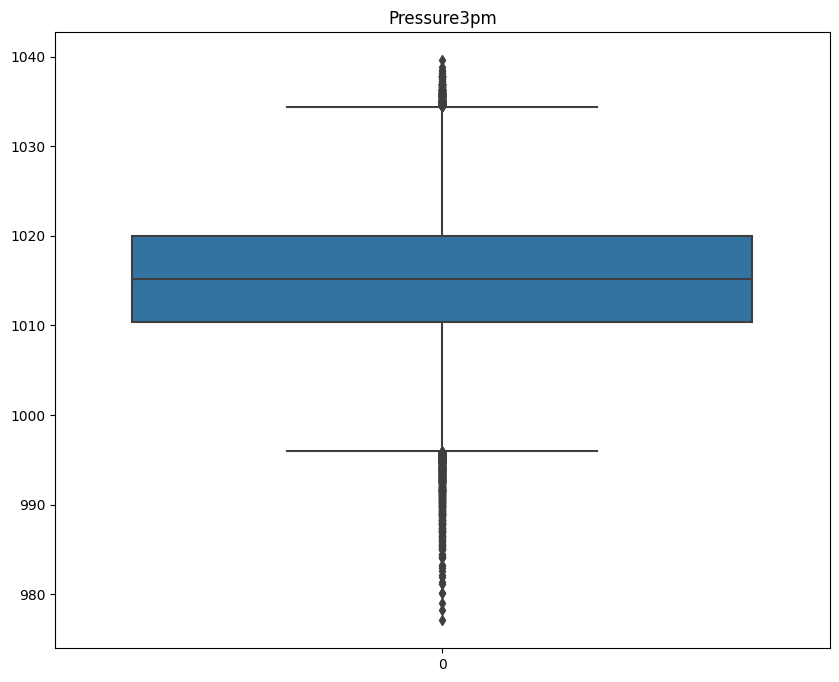

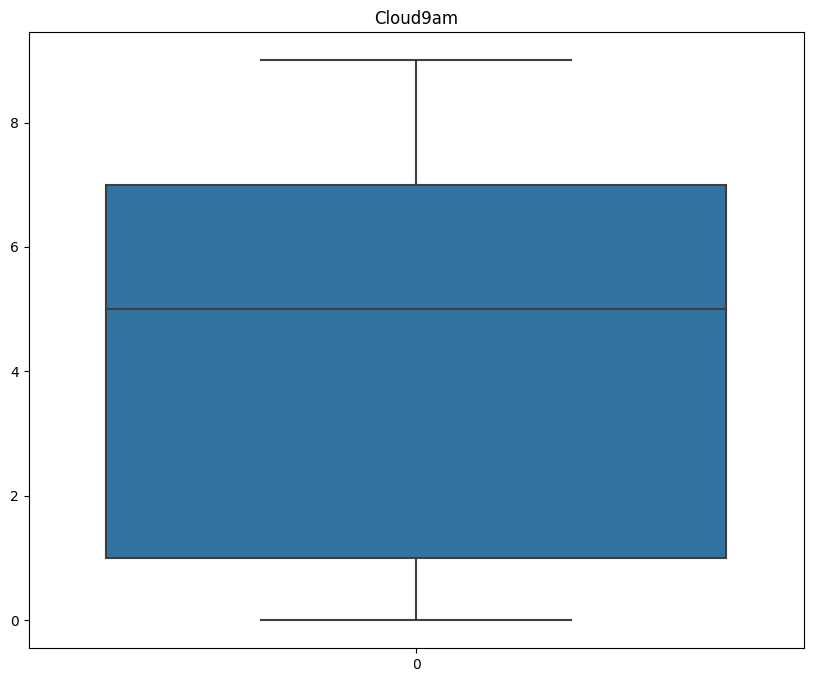

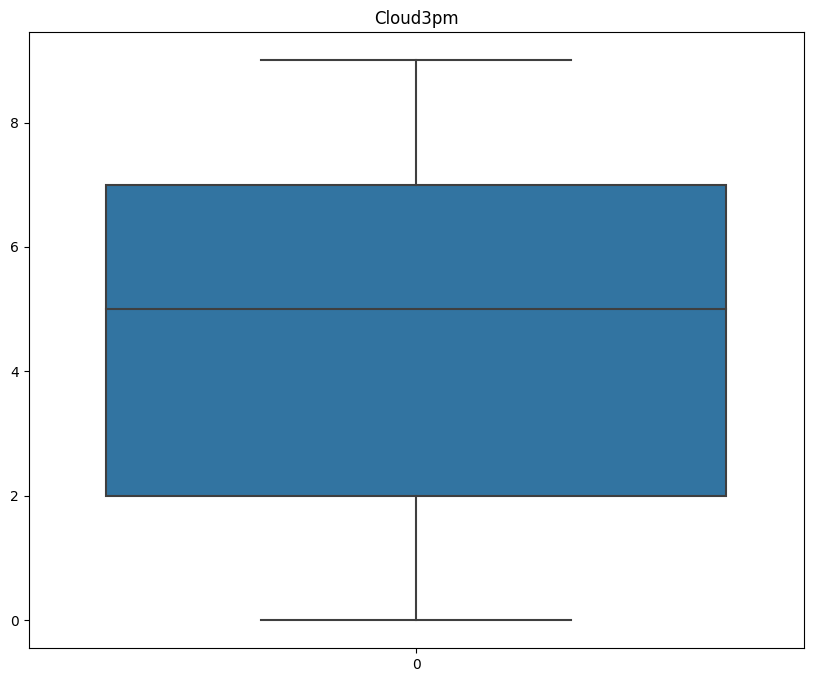

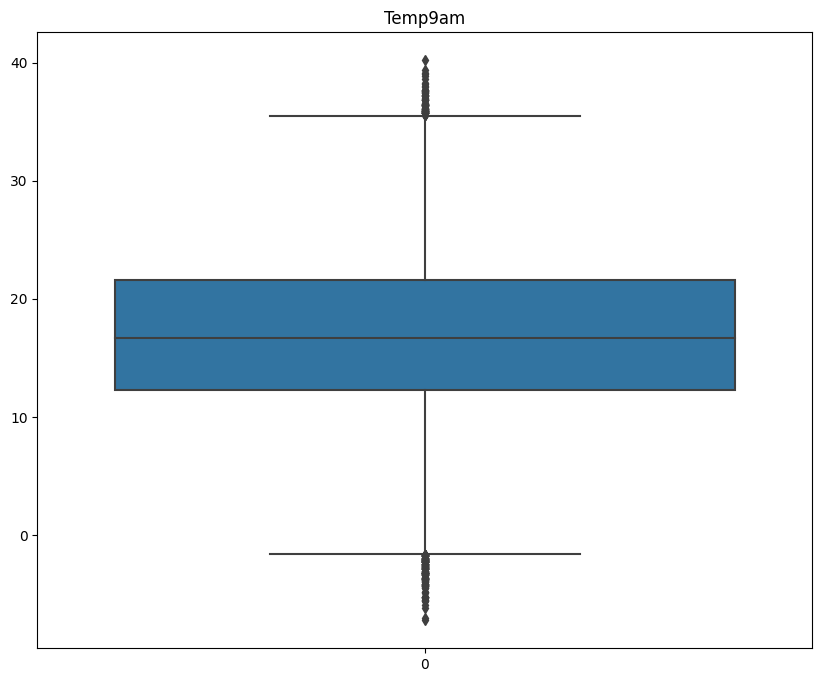

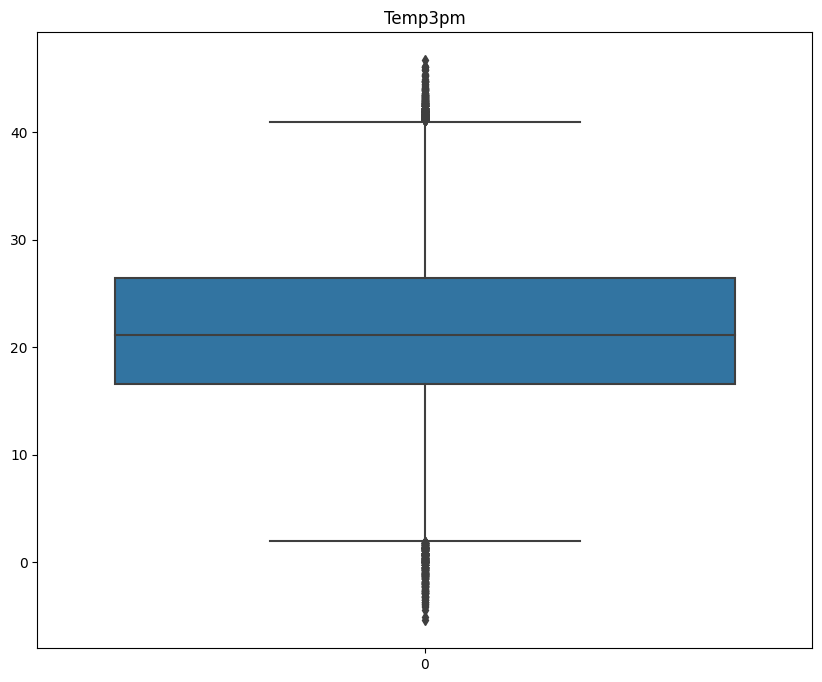

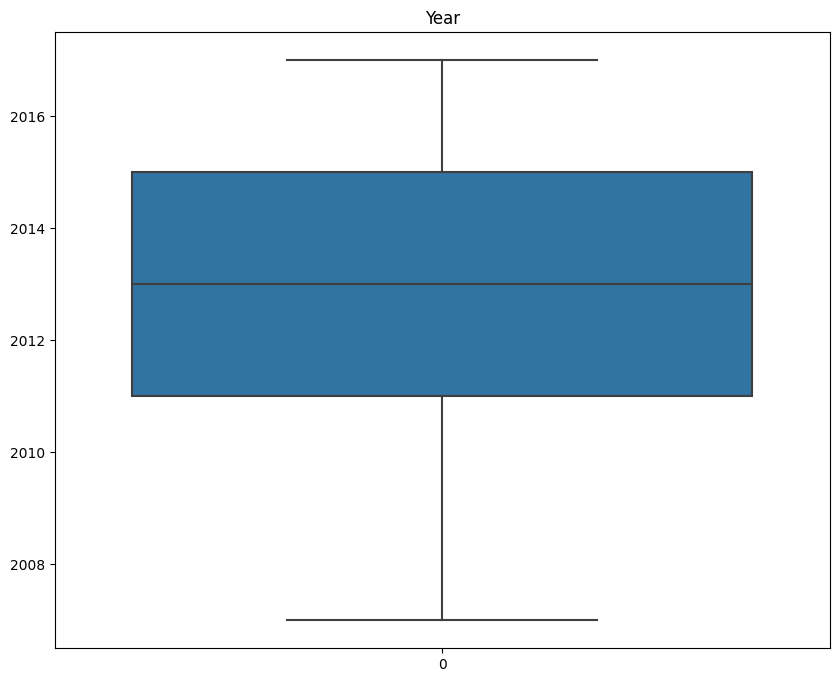

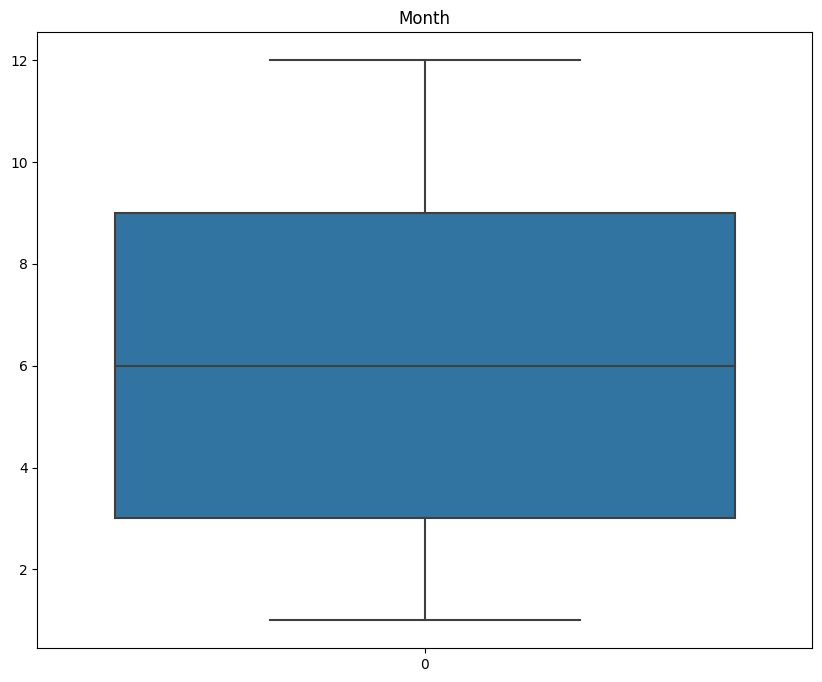

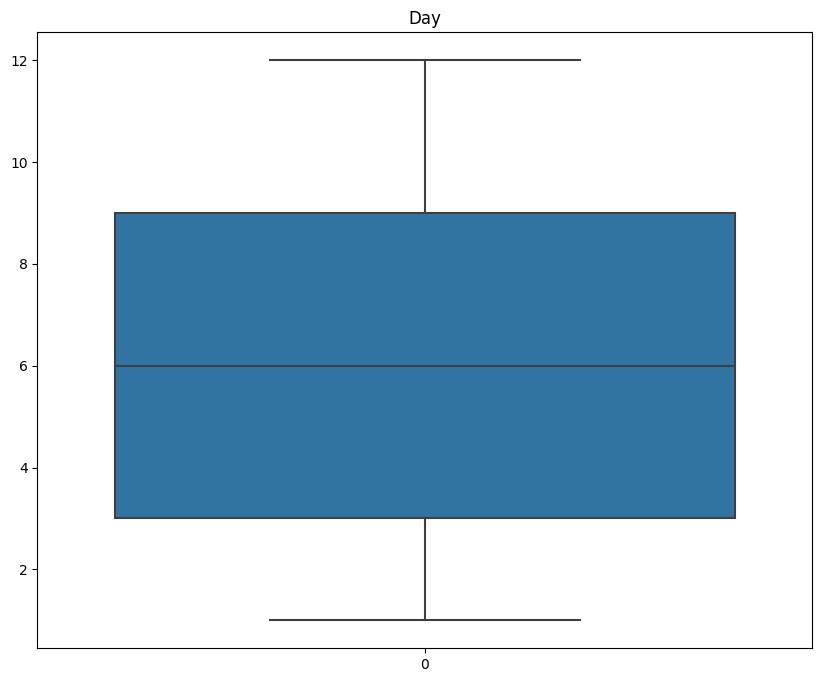

In [13]:
boxPlot(dataframe) 

- draw scatter plot to detect outliers

In [14]:
def scatterPlot(dataframe,col):
    figure, axes = plt.subplots(figsize=(10, 8))
    sns.scatterplot(dataframe[col],ax=axes)
    axes.set_title(col)

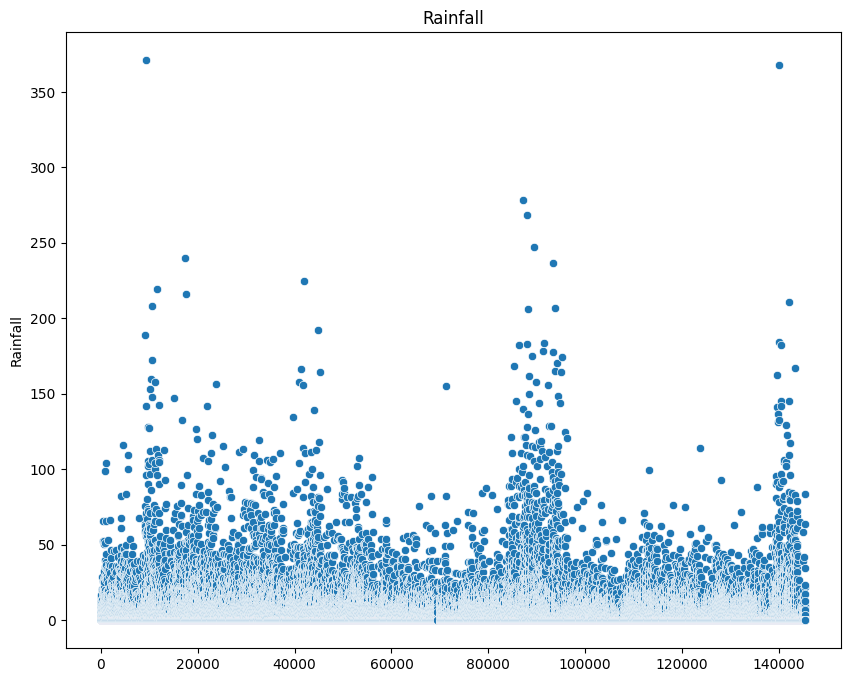

In [15]:
scatterPlot(dataframe,'Rainfall')

- use KNN to impute missing values

In [16]:
def impute_KNN(df):
    imputer = KNNImputer(n_neighbors=10)
    imputed = imputer.fit_transform(df)
    df_imputed = pd.DataFrame(imputed, columns=df.columns)
    return df_imputed

- this method returns the lower and the upper bound of a feature

In [17]:
def find_outliers(dataframe, col):
    q1 = dataframe[col].quantile(0.25)
    q3 =dataframe[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    return [lower_bound,upper_bound]

- this method imputes qualitative missing data and convert them to numerical

In [18]:
def impute_and_convert(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == 'object':
            # impute missing values with the mode of the column
            dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)
            # convert column to numerical representation
            dataframe.loc[:, col] = dataframe[col].astype('category').cat.codes
    return dataframe

In [19]:
def clean_data(dataframe):
    # remove duplicate rows
    dataframe=dataframe.drop_duplicates()

    # convert non-numerical values to numerical
    dataframe= impute_and_convert(dataframe)

    # fill in the missing data with KNN
#     dataframe= impute_KNN(dataframe)
    ## instead of filling let's just drop NAN
    dataframe.dropna(inplace=True)
    # these features were detected to have outliers using EDA
    outliers=['Rainfall','WindSpeed3pm','WindGustSpeed','WindSpeed9am','Humidity9am','Pressure3pm','Pressure9am','Temp3pm','Temp9am','MaxTemp']
    # handle outliers
    for col in outliers:
        outliers_bounds = find_outliers(dataframe,col)
        dataframe[col]=np.where(dataframe[col]>outliers_bounds[1],outliers_bounds[1],np.where(dataframe[col]<outliers_bounds[0],outliers_bounds[0],dataframe[col]))
    # return cleansed datadrame
    return dataframe

In [20]:
dataframe=clean_data(dataframe)
dataframe.describe()

/tmp/ipykernel_25/42500137.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)
/tmp/ipykernel_25/42500137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)
/tmp/ipykernel_25/42500137.py:5: FutureWarning: A value is tryi

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
count,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000
mean,13.335368,24.122936,0.384214,5.442443,7.694000,40.363160,15.141038,19.507384,66.298226,49.709698,1017.350161,1014.893449,4.250824,4.330964,18.078949,22.622406,2012.218164,6.411189,6.411189
std,6.465612,6.973724,0.609743,3.690139,3.766318,12.725026,8.225336,8.316102,18.422236,20.212989,6.856100,6.832374,2.802908,2.649844,6.603741,6.834186,2.447629,3.425273,3.425273
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,17.500000,0.000000,998.750000,996.000000,0.000000,0.000000,-0.900000,3.700000,2007.000000,1.000000,1.000000
25%,8.400000,18.600000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,36.000000,1012.700000,1010.100000,1.000000,2.000000,12.900000,17.300000,2010.000000,3.000000,3.000000
50%,13.100000,23.800000,0.000000,4.800000,8.600000,39.000000,15.000000,19.000000,67.000000,51.000000,1017.300000,1014.800000,5.000000,5.000000,17.700000,22.300000,2012.000000,6.000000,6.000000
75%,18.300000,29.600000,0.600000,7.400000,10.700000,48.000000,20.000000,24.000000,80.000000,63.000000,1022.000000,1019.500000,7.000000,7.000000,23.200000,27.800000,2014.000000,9.000000,9.000000
max,31.400000,46.100000,1.500000,81.200000,14.500000,73.500000,36.500000,40.500000,100.000000,100.000000,1035.950000,1033.600000,8.000000,9.000000,38.650000,43.550000,2017.000000,12.000000,12.000000


- feature scaling using minmax

In [21]:
def min_max(dataframe):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(dataframe)
    return pd.DataFrame(scaled, columns=dataframe.columns)

In [22]:
dataframeScaled = min_max(dataframe)
dataframeScaled.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
count,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,...,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000,58236.000000
mean,0.498724,0.525863,0.476737,0.256143,0.067025,0.530621,0.499056,0.486251,0.467686,0.505543,...,0.502485,0.531353,0.481218,0.479872,0.474841,0.220156,0.218576,0.521816,0.491926,0.491926
std,0.284546,0.169701,0.166041,0.406495,0.045445,0.259746,0.319510,0.197287,0.309804,0.313638,...,0.181712,0.350363,0.294427,0.166972,0.171498,0.414355,0.413284,0.244763,0.311388,0.311388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.266667,0.396325,0.345238,0.000000,0.034483,0.344828,0.200000,0.341085,0.200000,0.200000,...,0.375000,0.125000,0.222222,0.348925,0.341280,0.000000,0.000000,0.300000,0.181818,0.181818
50%,0.533333,0.519685,0.469048,0.000000,0.059113,0.593103,0.533333,0.465116,0.466667,0.533333,...,0.500000,0.625000,0.555556,0.470291,0.466750,0.000000,0.000000,0.500000,0.454545,0.454545
75%,0.755556,0.656168,0.607143,0.400000,0.091133,0.737931,0.800000,0.604651,0.733333,0.800000,...,0.625000,0.875000,0.777778,0.609355,0.604768,0.000000,0.000000,0.700000,0.727273,0.727273
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Coralaation

- draw heat map to check data corelation

In [23]:
def heatMap(dataframe):
    figure12, axes12= plt.subplots()
    sns.set(rc = {'figure.figsize':(10,8)})
    sns.heatmap(dataframe.corr(), ax=axes12,annot = True,fmt='.2g',cmap= 'crest')

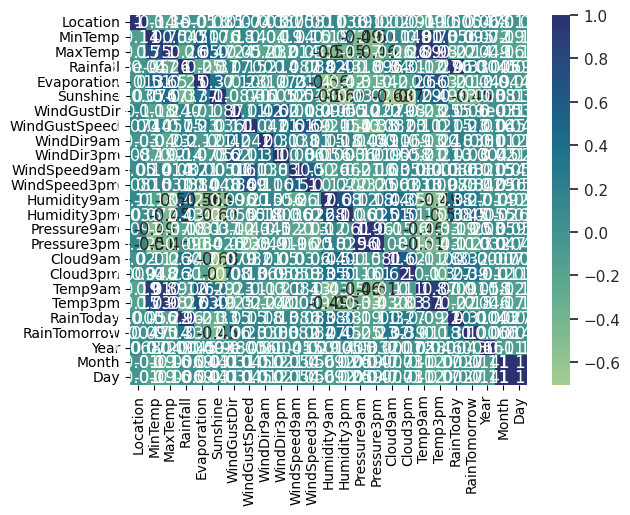

In [24]:
heatMap(dataframeScaled)

- based in the correlation between features

In [25]:
def select_features(dataframe):
    dataframe= dataframe[['Month', 'Location','MinTemp','MaxTemp','Humidity9am','Humidity3pm','WindGustSpeed','WindDir9am','WindDir3pm','Cloud9am','Cloud3pm','RainTomorrow','RainToday']]
    return dataframe

In [26]:
dataframeScaled= select_features(dataframeScaled)
dataframeScaled.head()

,Month,Location,MinTemp,MaxTemp,Humidity9am,Humidity3pm,WindGustSpeed,WindDir9am,WindDir3pm,Cloud9am,Cloud3pm,RainTomorrow,RainToday
0,0.0,0.155556,0.645669,0.740476,0.030303,0.13,0.604651,0.066667,0.800000,0.250,0.555556,0.0,0.0
1,0.0,0.155556,0.658793,0.590476,0.151515,0.08,0.434109,0.666667,0.666667,0.125,0.111111,0.0,0.0
2,0.0,0.155556,0.685039,0.797619,0.296970,0.22,0.573643,0.333333,0.400000,0.125,0.666667,0.0,0.0
3,0.0,0.155556,0.750656,0.816667,0.236364,0.22,0.341085,0.933333,1.000000,0.125,0.555556,0.0,0.0
4,0.0,0.155556,0.811024,0.878571,0.018182,0.15,0.403101,0.466667,0.933333,0.125,0.666667,0.0,0.0


- split the data and drop the target feature

In [27]:
X = dataframeScaled.drop(['RainTomorrow'], axis=1)
Y = dataframeScaled['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

## Chapter two: Classification Algorithms


this function is used to return performance measure for the model three models will be passed through this function are:

- SVC()
- MLPClassifier()
- LogisticRegression()

In [28]:
def evaluate_model(model, x_test, y_test, X_train, Y_train):
    if isinstance(model, SVC):
        model = SVC(probability=True)
    
    if isinstance(model, MLPClassifier):
        model = MLPClassifier(max_iter=1000)

    # Calculate accuracy measurments
    model.fit(X_train, Y_train)
    y_pred = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # Calculate auc
    y_pred_proba = model.predict_proba(x_test)[::,1]
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # confussion matrix
    confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
    return [ accuracy, precision, recall, f1, auc, confusionMatrix ]

- Evaluation returned array content: accuracy, precision, recall, f1, auc, confusionMatrix

- cross validation and plot learning curve

In [29]:
def cv_learnCurve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    figure, axes = plt.subplots()
    axes.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    axes.plot(train_sizes, test_scores.mean(axis=1), label='Test score')
    axes.set_xlabel('Training examples')
    axes.set_ylabel('Score')
    axes.legend(loc='best')

- Train & evaluate logetsic regression model and get predictions

Logestic regression Model Results:  [0.8507898351648352, 0.7409297052154195, 0.5050231839258115, 0.6006433823529412, 0.8703942205663087, array([[8603,  457],
       [1281, 1307]])]


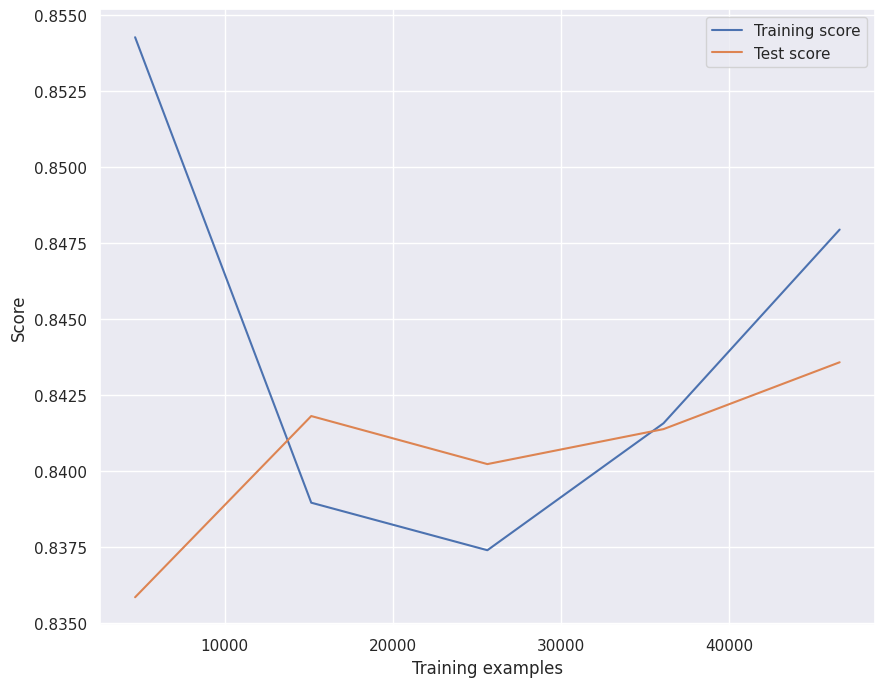

In [30]:
lr_results = evaluate_model(LogisticRegression(), X_test, y_test, X_train, y_train)
print("Logestic regression Model Results: ", lr_results)
cv_learnCurve(LogisticRegression(),X, Y)

- Train and evaluate ANN model and get predictions

In [31]:
ann_results = evaluate_model(MLPClassifier(), X_test, y_test, X_train, y_train)
print("ANN Model Results: ", ann_results)
# cv_learnCurve(MLPClassifier(),X, Y)

ANN Model Results:  [0.8549107142857143, 0.7622663551401869, 0.5042503863987635, 0.6069767441860465, 0.8791129717391526, array([[8653,  407],
       [1283, 1305]])]


- Train & evaluate SVM model and get predictions

In [32]:
svm_results = evaluate_model(SVC(), X_test, y_test, X_train, y_train)
print("SVM Model Results: ", svm_results)
# cv_learnCurve(SVC(),X, Y)

SVM Model Results:  [0.8525927197802198, 0.7968643490115883, 0.4517001545595054, 0.5765721331689273, 0.8236441071203141, array([[8762,  298],
       [1419, 1169]])]
